## Modèle de Biomasse Sèche REPO

In [ ]:
# change this flag to True if you are running this notebook in Google Colab, it will install the required dependencies in the next cell
COLAB = False 

In [ ]:
if COLAB:
  !git clone https://github.com/gutkinn/REPO-biomasse.git
  %cd REPO-biomasse
  import os
  import yaml

  with open("environnement.yml") as file_handle:
    environment_data = yaml.safe_load(file_handle)

  for dependency in environment_data["dependencies"]:
      if isinstance(dependency, dict):
        for lib in dependency['pip']:
          os.system(f"pip install {lib}")
      else:
        os.system(f"pip install {dependency}")
  print('Ok, good to go!')

#### Importation des paquets nécessaires

Tous les paquets Python doivent être importés pour le fonctionnement correct du modèle. S'il y a un paquet qui manque, suivez les instructions dans le fichier 'README.MD' pour l'installer.

In [31]:
import geopandas as gpd
import openeo
import json
import os
from scipy import stats
import matplotlib.pyplot as plt
from shapely import geometry, buffer

#### Fonctions supplémentaires

Les fonctions ici sont le moteur du Notebook, elles font toutes les calculs avec des variables définies à chaque étape.

In [3]:
from helpers import *

### Étape 1. Extraction des données satellitaires (points d'entraînement)

Ici nous definissons toutes les variables qui seront nécessaires aux premières étapes de la prédiction de biomasse sèche. Les données biomasses collectées en terrain doivent être déjà préparées en avance - suivez les instructions dans le fichier 'Préparation_des_données.txt'.

In [32]:
sites_csv = pd.read_csv(r'./in_data/donnees_sites.csv')
sites_points = [geometry.Point(x,y) for x,y in zip(sites_csv['Long (E)'],sites_csv['Lat (N)'])]
sites_gdf = gpd.GeoDataFrame(sites_csv,crs='epsg:4326',geometry=sites_points)
sites_gdf['geometry'] = buffer(sites_gdf.geometry.to_crs(3857),30).set_crs(3857).to_crs(4326)
sites_gdf.to_file(r'./in_data/donnees_sites.gpkg')

In [4]:
prodsites = gpd.read_file(r'./in_data/donnees_sites.gpkg') # location des données biomasses dans les fichiers

# bandes satellitaires Sentinel-1 et Sentinel-2 dont nous aurons besoin
band_list_s1 = ['VV','VH']
band_list_s2 = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12','SCL']

# créneau temporaire pour l'extraction des données satellitaires
t = ['2023-01-01','2023-12-31']

# ici nous réorganisons les données de biomasse et les dates de collection
all_dates = ['date_fev','date_avr','date_sep']
all_biomass = ['biomass_fev','biomass_avr','biomass_sep']
prodsites['dates'] = prodsites.apply(create_list,axis=1,args=(all_dates,))
prodsites['biomass'] = prodsites.apply(create_list,axis=1,args=(all_biomass,True))

# création des géométries pour l'extraction des données satellitaires 
bbox_simple = {"west":prodsites.geometry.to_crs(crs=3857).centroid.to_crs(4326).x.min()-0.0001,
               "south":prodsites.geometry.to_crs(crs=3857).centroid.to_crs(4326).y.min()-0.0001,
               "east":prodsites.geometry.to_crs(crs=3857).centroid.to_crs(4326).x.max()+0.0001,
               "north":prodsites.geometry.to_crs(crs=3857).centroid.to_crs(4326).y.max()+0.0001}

geoms = json.loads(prodsites.explode(index_parts=True).geometry.to_json())


Puis, il faut se connecter au service openEO pour être autorisé à extraire les données satellitaires. Pour créer un compte openEO, suivez les instructions ici : https://docs.openeo.cloud/join/free_trial.html 

In [35]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=HBSE-QYSC 📋 to authenticate.

[################################-----] ✅ Authorized successfully

Authenticated using device code flow.


Quand vous êtes connectés à openEO, vous pouvez envoyer un 'job': dont une demande d'extraire les données satellitaires pour tous les points d'entraînement. Ces données seront téléchargées dans votre fichier 'data' et peuvent être utilisées pour l'entraînement des modèles. 

In [ ]:
points_out = os.path.join('.','out_data',f'points_biomasse.json')

#extract training points
extr_agg = extract_and_save_simple(band_list_s1,band_list_s2,t,bbox_simple,geoms,connection)

# Changez le titre pour suivre les étapes d'extraction en ligne
job = extr_agg.create_job(
        title='extraction_points', out_format="JSON") 

job.start_and_wait()

for asset in job.get_results().get_assets():
    asset.download(points_out)

### Étape 2. Entraînement des modèles 

Nous pouvons ouvrir le fichier pour vérifier la qualité des données téléchargées ici.

In [5]:
dict_dates = {}

extr_data = pd.concat([prodsites['ID Point'],pd.read_json(points_out,convert_axes=False)],axis=1)
extr_data = extr_data[['ID Point']+list(extr_data.keys()[1:].sort_values())]

for key in extr_data.columns.values[1:]:
    dict_dates[key] = key[:10]
extr_data.rename(columns=dict_dates,inplace=True)


Après le téléchargement, les données satellitaires sont organisées par date (colonne) et placeau central (ligne). Mais pour construire des modèles robusts, c'est mieux de prendre une moyenne de tous les placeaux au niveau de 'Groupe'. Puis, il faut réorganiser les données telles que nous puisons voir la troisieme dimension des données, soit les bandes satellitaires. Dans cette étape nous allons nettoyer les données (supprimer les captures vides - NaN) et calculer les indices végétaux. 

In [42]:
# toutes les bandes qu'on va utiliser dans les modèles
all_indexes = ['VV', 'VH', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
               'B8A', 'B11', 'B12', 'NDVI', 'NDWI', 'GRVI', 'GNDVI', 'NBR',
               'NBR2', 'NDI54', 'NDRE1', 'STI', 'MSI',  'SAVI', 'MSAVI', 'IRECI',
               'VV-VH_rolling','VV+VH_rolling']

# ici nous allons agréger les données biomasse au niveau du pixel (2 groupes dans chaque pixel)
list_l1 = list(np.unique([p.split('_')[0] + '_' + p.split('_')[1] for p in prodsites['ID Point'] if '45_' not in p]))

biomass_list = []
i=0

for idx_l1 in list_l1:
    
    merge_biomass, merge_rows = match_satellite_biomass(idx_l1,extr_data,prodsites,band_list_s1 + band_list_s2)
    biomass_vals, matched_index_vals = generate_corr(merge_biomass,merge_rows,all_indexes,0)
    biomass_list+=biomass_vals

    if i==0:
        index_list = np.array(matched_index_vals)
    else:
        index_list = np.append(index_list,np.array(matched_index_vals),axis=1)
    i+=1
        
# réorganisation des données temporelles (t1 = février, t2 = avril, t3 = septembre)
all_l1_time = np.array([[l+'_t1',l+'_t2',l+'_t3'] for l in list_l1]).reshape(index_list.shape[1])

# nettoyage des données biomasse, données avec score z > 2 sont retirées
z_b = np.abs(stats.zscore(biomass_list))
z_b_o = np.where(z_b > 2)[0]
index_list = np.array(pd.DataFrame(index_list).drop(columns=z_b_o))
biomass_list = np.delete(biomass_list,z_b_o)
all_l1_time = np.delete(all_l1_time,z_b_o)

Maintenant, nous avons deux tableaux importants : 
 - index_list : un tableau contenant toutes les données des bandes satellitaires et indices
 - biomass_list : un tableau contenant toutes les données biomasse 
 
Chaque tableau doit avoir la même forme (mais à l'envers). Par example:

 - index_list.shape = (28,228) = (número des bandes, número des points)
 - biomass_list.shape = (228,) =  (número des points,)

D'ici, nous pouvons commencer à entrainer les modèles avec les données. Il y a trois options pour les modèles : régression linéaire (régressions polynomiales inclus), moindres carrés partiels, et Random Forests (machine learning). Nous allons comparer les scores R² et Mean Absolute Error (MAE) pour déterminer leurs précisions et décider que modèle faut-il utiliser. 

In [43]:
X_df = pd.DataFrame(index_list.T,columns=all_indexes,index=all_l1_time)
y_df = pd.DataFrame(biomass_list,columns=['biomass'],index=all_l1_time)

model_dict = print_models(X_df,y_df)

Modèle régression linéaire (1°)
Min MAE: itération 5 score 160.105
Max R²: itération 19 score 0.666
Bandes restantes : ['B05' 'B12' 'NDVI' 'NBR2' 'NDI54' 'STI' 'SAVI' 'MSAVI' 'IRECI']


Modèle régression polynomiale (2°)
Min MAE: itération 21 score 184.022
Max R²: itération 26 score 0.602
Bandes restantes : ['NBR2' 'NDI54']


Modèle régression polynomiale (3°)
Min MAE: itération 26 score 183.752
Max R²: itération 26 score 0.604
Bandes restantes : ['NBR2' 'NDI54']


Modèle moindre carrés partiels (PLS)
Min MAE : itération 6 score 160.378
Max R² : itération 22 score 0.686
Bandes restantes : ['NDVI' 'NDWI' 'NBR' 'NBR2' 'SAVI']


Modèle Random Forests (RF)
Min MAE : itération 17 score 188.815
Max R² : itération 25 score 0.562
Bandes restantes : ['B12' 'NDI54' 'IRECI']


En regardant les résultats, nous voyons que le modèle linéaire est le plus précise (R² score le plus grand, MAE le plus bas). 

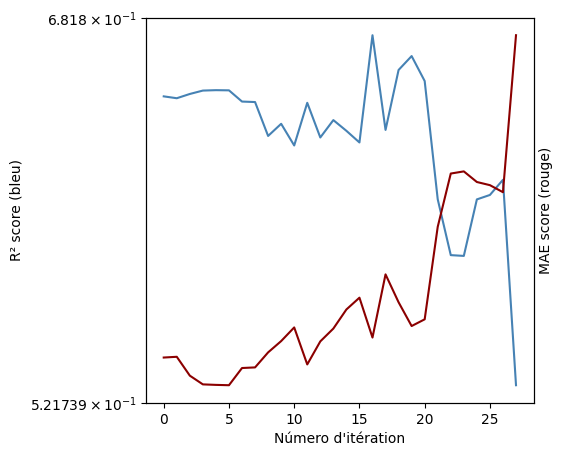

In [18]:
mae_scores,r2_scores,remaining_feats,[y_test,preds] = iterate_train_test(X_df,y_df,split=0.25,it_mode='LR',degree=1)
f,ax = plt.subplots(figsize=(5,5))
ax.plot([n for n in range(len(r2_scores))],r2_scores.values(),color='steelblue')
ax2 = ax.twinx()
ax2.plot([n for n in range(len(r2_scores))],mae_scores.values(),color='darkred')
ax.set_ylabel('R² score (bleu)')
ax.set_yscale('symlog')
ax2.set_yscale('symlog')
ax.set_xlabel("Número d'itération")
ax2.set_ylabel('MAE score (rouge)')
plt.show()

Considering the data above, we're going to choose the model with the highest R² score. We will use the get_best_model() function to get the model object which we will apply to our area of interest to generate biomass predictions.

We have loaded the 'best' available model, now we need to fetch the input data for our area of interest. We will do so via openEO, getting the data for a predefined polygon and downloading it to conduct inference locally using the model we have defined. The download process may take a long time, as depending on the size of the specified area there may be a very large amount of data.

In [7]:
loc = 'DanGoulbi'
mois = 'fev'
area = gpd.read_file(f'./in_data/locations/{loc}.gpkg').to_crs(epsg=4326)

In [ ]:
loc = 'Tesker'
mois = 'fev'
area = gpd.read_file(f'./in_data/locations/{loc}.gpkg').to_crs(epsg=4326)
bounds = area.total_bounds
in_data_path = os.path.join('.','out_data',f'{loc}_{mois}_100m.nc')
band_list_s1 = ['VV','VH']
band_list_s2 = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']

# IMPORTANT : Il faut selectionner le mois entier pour avoir des prédictions de biomasse correctes
t_extract = ['2023-02-01', '2023-02-28']

bbox = {'west':bounds[0],
        'south':bounds[1],
        'east':bounds[2],
        'north':bounds[3],
        'crs':area.crs.to_string()}

extr_area = extract_and_save_simple(band_list_s1,band_list_s2,t_extract,bbox,None,connection)

job = extr_area.create_job(
        title=f'avr_{loc}', out_format="NetCDF")

job.start_and_wait()
for asset in job.get_results().get_assets():
    asset.download(in_data_path)

Des que les données ont été téléchargées, nous pouvons appliquer les modèles directement aux données pour générer des prédictions de la biomasse sèche. Avant d'applique le modèle, c'est important de calculer les mêmes indices vegetales lesquelles ont été utilisés pour l'entraînement du modèle. Nous allons le faire avec la fonction add_indices().  

In [8]:
in_data_path = os.path.join('.','out_data',f'{loc}_{mois}_100m.nc')
in_data = xr.open_dataset(in_data_path)
add_indices(in_data,rolling=True)
in_crs = in_data['crs'].attrs['crs_wkt']
in_data = in_data.drop_vars(['crs']).mean(dim='t')
in_data

<xarray.Dataset>
Dimensions:        (x: 548, y: 390)
Coordinates:
  * x              (x) float64 6.342 6.343 6.344 6.345 ... 6.827 6.827 6.828
  * y              (y) float64 14.14 14.14 14.14 14.14 ... 13.8 13.8 13.8 13.8
Data variables: (12/30)
    VV             (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    VH             (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B01            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B02            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B03            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    B04            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...             ...
    MSI            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    SAVI           (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    MSAVI          (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    IRECI          (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    VV-VH_rolling  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    VV+VH_rolling  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

Finalement, c'est l'heure de générer des prédictions de la biomasse sèche utilisant les modèles dont nous avons entraîné et les données satellitaires dont nous avons téléchargé dans les étapes précedents. Les prédictions de biomasse seront calculé avec un minimum de 0kgMS/ha, même si le modèle nous donne une prédiction de biomasse negative. En changeont la variable _degree_, nous pouvons changer le modèle que nous allons utiliser. Si vous vous rappelez, le modèle de régression lineaire était le plus precise, donc nous allons continuer avec ce modèle (_degree_ = 1).

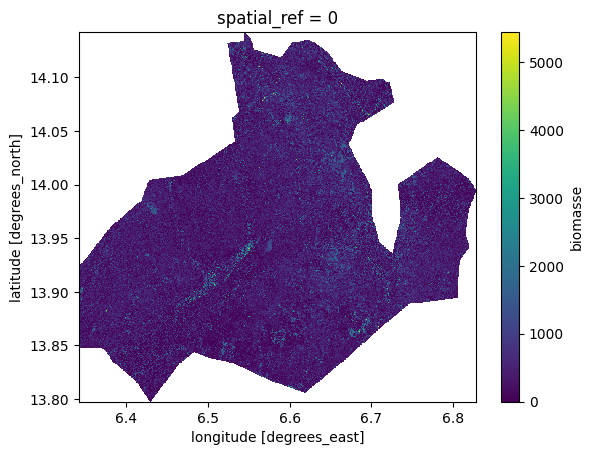

In [12]:
# Modèle RF: degree = -1
# Modèle PLS: degree = 0
# Modèle LR: degree = 1
# Modèle poly 2°: degree = 2
# Modèle poly 3°: degree = 3 
degree = 2
X_df = pd.DataFrame(index_list.T,columns=all_indexes,index=all_l1_time)
y_df = pd.DataFrame(biomass_list,columns=['biomass'],index=all_l1_time)
out_path = in_data_path.replace('100m','MODEL').replace('.nc','.tif')

if degree == -1:
    mae_scores,r2_scores,remaining_feats,preds = iterate_train_test(X_df,y_df,split=0.25,it_mode='RF')
    model = get_best_model(X_df[remaining_feats[max(r2_scores,key=r2_scores.get)]],y_df,'RF')
    predict_and_save(model,in_data,in_crs,out_path,area.geometry,it_mode = 'RF')
    
if degree == 0:
    mae_scores,r2_scores,remaining_feats,preds = iterate_train_test(X_df,y_df,split=0.25,it_mode='PLS')
    model = get_best_model(X_df[remaining_feats[21]],y_df,'PLS',degree)
    coef = dict(zip(remaining_feats[21],model.coef_[0]))
    predict_and_save(model,in_data,in_crs,out_path,area.geometry,it_mode='PLS',coef=coef)

if degree == 1:
    mae_scores,r2_scores,remaining_feats,preds = iterate_train_test(X_df,y_df,split=0.25,it_mode='LR',degree=degree)
    model = get_best_model(X_df[remaining_feats[max(r2_scores,key=r2_scores.get)]],y_df,'LR',degree)
    coef = dict(zip(remaining_feats[max(r2_scores,key=r2_scores.get)],model.coef_[0]))
    predict_and_save(model,in_data,in_crs,out_path,area.geometry,it_mode='LR',coef=coef,degree=degree)

if degree > 1:
    mae_scores,r2_scores,remaining_feats,preds = iterate_train_test(X_df,y_df,split=0.25,it_mode='LR',degree=degree)
    model,poly = get_best_model(X_df[remaining_feats[max(r2_scores,key=r2_scores.get)]],y_df,'LR',degree)
    coef = dict(zip(poly.get_feature_names_out(),model.coef_[0]))
    predict_and_save(model,in_data,in_crs,out_path,area.geometry,it_mode='LR',coef=coef,degree=degree)


### Validation

In [297]:
mae_scores,r2_scores,remaining_feats,preds = iterate_train_test(X_df,y_df,split=0.1,it_mode='PLS',degree=1)#'LR',degree=1)
model = get_best_model(X_df[remaining_feats[21]],y_df,'PLS',degree=1)#'LR',degree=1)
#coef = dict(zip(remaining_feats[max(r2_scores,key=r2_scores.get)],model.coef_[0]))

In [238]:
valsites = gpd.read_file(r'./in_data/donnees_sites_juin_buffer_filter.gpkg')
val_out = os.path.join('.','out_data',f'points_juin_filter_biomasse_2wk.nc')
t_val = ['2024-06-01','2024-06-15']

valsites['Site'] = valsites['Site'].str.replace('A','')
valsites['Site'] = valsites['Site'].str.replace('P_0','')
valsites['ID Point'] = valsites.apply(create_id_point,axis=1)
valsites = valsites[['ID Point','geometry']].set_index('ID Point')
bbox_val = {"west":valsites.geometry.centroid.x.min()-0.0001,
               "south":valsites.geometry.centroid.y.min()-0.0001,
               "east":valsites.geometry.centroid.x.max()+0.0001,
               "north":valsites.geometry.centroid.y.max()+0.0001}

geoms_val = json.loads(valsites.explode(index_parts=True).geometry.to_json())

extr_val = extract_and_save_simple(band_list_s1,band_list_s2,t_val,bbox_val,geoms_val,connection)

job = extr_val.create_job(
        title='validation_points', out_format="NetCDF") # Changez le titre pour suivre les étapes d'extraction en ligne

job.start_and_wait()

for asset in job.get_results().get_assets():
    asset.download(val_out)


C:\Users\GUTKINN\AppData\Local\Temp\ipykernel_24712\1701914962.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox_val = {"west":valsites.geometry.centroid.x.min()-0.0001,
C:\Users\GUTKINN\AppData\Local\Temp\ipykernel_24712\1701914962.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "south":valsites.geometry.centroid.y.min()-0.0001,
C:\Users\GUTKINN\AppData\Local\Temp\ipykernel_24712\1701914962.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "east":valsites.geometry.centroid.x.max()+0.0001,
C:\Users\GUTKINN\AppData\Local\Temp\ipykernel_24712\1701914962.py:1

0:00:00 Job 'vito-j-24092732e4344127ad2296b061968be5': send 'start'
0:00:19 Job 'vito-j-24092732e4344127ad2296b061968be5': queued (progress 0%)
0:00:25 Job 'vito-j-24092732e4344127ad2296b061968be5': queued (progress 0%)
0:00:32 Job 'vito-j-24092732e4344127ad2296b061968be5': queued (progress 0%)
0:00:40 Job 'vito-j-24092732e4344127ad2296b061968be5': queued (progress 0%)
0:00:50 Job 'vito-j-24092732e4344127ad2296b061968be5': queued (progress 0%)
0:01:04 Job 'vito-j-24092732e4344127ad2296b061968be5': queued (progress 0%)
0:01:20 Job 'vito-j-24092732e4344127ad2296b061968be5': running (progress N/A)
0:01:40 Job 'vito-j-24092732e4344127ad2296b061968be5': running (progress N/A)
0:02:04 Job 'vito-j-24092732e4344127ad2296b061968be5': running (progress N/A)
0:02:34 Job 'vito-j-24092732e4344127ad2296b061968be5': running (progress N/A)
0:03:13 Job 'vito-j-24092732e4344127ad2296b061968be5': running (progress N/A)
0:04:00 Job 'vito-j-24092732e4344127ad2296b061968be5': running (progress N/A)
0:04:59 

In [298]:
valsites = gpd.read_file(r'./in_data/donnees_sites_juin_buffer_filter.gpkg')
valsites['Site'] = valsites['Site'].str.replace('A','')
valsites['Site'] = valsites['Site'].str.replace('P_0','')
valsites['ID Point'] = valsites.apply(create_id_point,axis=1)


In [299]:
val_data = xr.open_dataset(val_out)
val_feats = val_data['feature_names']
val_data = val_data.drop_vars(['feature_names','SCL']).mean(dim='t')
add_indices(val_data,rolling=True)
coef_calcs = get_coef_calcs(val_data,coef,1)
intercept = model.intercept_[0]
val_data['feature'] =np.array(valsites['ID Point'])

In [302]:
pred = val_data.to_dataframe()[remaining_feats[21]].dropna()

In [303]:
pred['biomasse'] = model.predict(pred)
pred = pred.reset_index()

In [304]:
pred

,feature,B04,B05,NDVI,NBR,NBR2,SAVI,biomasse
0,45_1_1,3543.200000,3906.600000,0.081216,-0.088951,0.079903,0.121816,-3.509295
1,45_1_2,3359.428571,3731.000000,0.084125,-0.100788,0.075817,0.126179,-0.620597
2,45_2_1,3743.333333,3987.000000,0.061272,-0.057776,0.084453,0.091903,-19.982652
3,45_2_2,3575.500000,3931.000000,0.047232,-0.091435,0.087024,0.070843,-8.592122
4,45_3_1,3838.000000,4131.916667,0.063141,-0.032972,0.092582,0.094705,-8.157312
...,...,...,...,...,...,...,...,...
110,42_1_1,3492.571429,3889.142857,0.100052,-0.107687,0.076649,0.150068,-1.108916
111,42_1_2,3521.142857,3902.857143,0.098991,-0.101655,0.076337,0.148477,-2.479957
112,42_2_1,3598.857143,3968.000000,0.092507,-0.108367,0.069905,0.138752,-7.143830
113,115_1_1,3946.500000,4251.750000,0.096032,-0.073908,0.075516,0.144039,-16.495655


In [254]:
pred2 = intercept + sum(coef_calcs)
pred2 = pred2.to_dataset(name='biomasse')
#pred = pred.where(pred['biomasse'] > 0, 0)
pred2['feature'] =np.array(valsites['ID Point'])
pred2.biomasse

<xarray.DataArray 'biomasse' (feature: 128)>
array([ 7.68520035e+00,  1.03365244e+01, -7.40438829e+00,  7.63626204e+00,
       -9.68769553e-01,  1.24156822e+01,  9.16724519e+00,  1.03824075e+01,
        1.09572720e+01,  7.45257129e+00,  1.13700485e+01,  2.27310764e+00,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  8.60230441e+00,  7.60450783e+00,  6.17117925e+00,
        7.82891440e+00,  1.80871568e+00,  3.00592205e+00,  4.80629906e+00,
        7.02109630e+00,  6.44907317e+00,  1.66282015e+01,  6.31329151e+00,
        3.61268021e+00,  2.96206535e+00,  4.99038818e+00,  9.46710271e+00,
        5.37988711e+01,  1.00676306e+01,  7.21893011e+00,  5.75553321e+00,
        3.71722544e+00,  3.76378612e+00,  5.90521069e+00, -9.62088154e-01,
        9.24782071e+00,  8.41073105e+00,  1.13520981e+01,  5.70315973e+00,
        1.50112935e-02,  6.20973645e+00,  1.29371054e+01,  1.88063885e+00,
        1.48231128e+01, -2.36243150e+00,  6.16545065e+00,  7.35991525e+01,
        5.75886093e+00,  3.36837093e+00,  4.98542506e-01,  5.75966749e+00,
        5.08475573e+00,  2.50852963e+00,  6.11701610e+00,  1.77538571e+00,
        3.76788303e+00,  3.38475354e+00,  6.31561949e+00,  4.51975345e+00,
        7.11885416e+00,  2.68388205e+00,  2.17135063e+00,  5.05617739e+00,
        5.49880550e+00,  3.52815590e+00,  3.80026849e+00, -1.55074460e+00,
        1.11472263e+01, -3.64926021e+00,  4.63912506e+00, -4.09945285e+00,
        4.27440343e+00,  7.48030002e+00,  9.49815888e+00,  2.88591651e+00,
        8.66689622e+00,  8.86873771e+00,  1.40560906e+01,  1.23664324e+01,
        3.78986685e+00,  1.00010834e+01,  6.25429188e+00,  4.50539299e+00,
        5.56373371e+01,  3.12972750e+01,  1.35441728e+01,  1.00018624e+01,
        4.12107222e+01,  9.61954863e+00,  2.20531618e+01,  1.13706929e+01,
        7.84773372e+00,  1.00442421e+01,  1.14826259e+01,  1.21243008e+01,
        4.41512249e+00,  1.06403874e+01,  4.63854715e+00,  6.67784521e+00,
        4.77957185e+00,  2.18660979e+00,  3.20537706e+00,  5.23928886e+00,
        3.51701309e+00,  2.72014327e+00,  3.32580528e-01,  7.10601169e+00,
        2.49624380e+01,  8.75184586e+00,  1.31493634e+01,  1.16875966e+01,
        9.51250053e+00,  6.06061129e+00, -3.67564596e+00, -4.61689945e+00])
Coordinates:
    lat      (feature) float64 14.71 14.72 14.72 14.73 ... 13.96 13.88 13.87
    lon      (feature) float64 11.1 11.1 11.1 11.1 ... 11.43 11.43 11.06 11.02
  * feature  (feature) object '45_1_1' '45_1_2' '45_2_1' ... '115_1_1' '115_1_2'

In [200]:
pred_val

<xarray.Dataset>
Dimensions:   (feature: 168)
Coordinates:
    lat       (feature) float64 14.71 14.72 14.72 14.73 ... 13.98 13.58 13.38
    lon       (feature) float64 11.1 11.1 11.1 11.1 ... 11.06 11.06 11.06 11.06
  * feature   (feature) object '45_1_1' '45_1_2' ... '115_6_1' '115_6_2'
Data variables:
    biomasse  (feature) float64 -2.28 -1.349 -12.1 -6.261 ... 4.153 0.272 1.978

In [305]:
pred_val = pred[['feature','biomasse']]#.to_dataframe().reset_index().drop(columns=['lat','lon'])
true_val = valsites[['ID Point','Biomasse']]

In [308]:
true_val = true_val[true_val['ID Point'].isin(filter_id)]

In [307]:
filter_id = [val for val in valsites['ID Point'].values if val in pred_val['feature'].values]

In [309]:
mean_absolute_error(true_val,pred_val)

5.969617700872647

In [310]:
r2_score(true_val,pred_val)

-3.4645451653182135

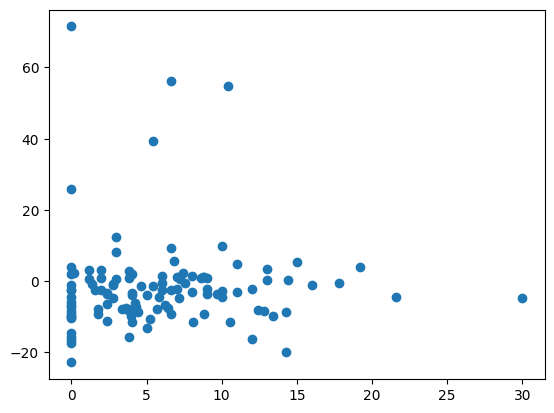

In [311]:
plt.scatter(true_val['Biomasse'].values,pred_val['biomasse'].values)